In [1]:
# import os, cv2
# import numpy as np
# import pandas as pd
# import random, tqdm
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import albumentations as album
# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.losses import DiceLoss
# import torchmetrics
# from segmentation_models_pytorch import utils
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [3]:
!pip install -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

The system cannot find the path specified.


## Read Data & Create train / valid splits 📁

In [4]:
DATA_DIR = "./data"

# Memuat metadata untuk data training dan validasi
train_metadata_df = pd.read_csv(os.path.join(DATA_DIR, "train_metadata_patches256.csv"))
valid_metadata_df = pd.read_csv(os.path.join(DATA_DIR, "valid_metadata_patches256.csv"))
test_metadata_df = pd.read_csv(os.path.join(DATA_DIR, "test_metadata_patches256.csv"))

# Pastikan bahwa kolom 'sat_image_path' dan 'mask_path' mengarah ke lokasi yang benar
train_metadata_df["sat_image_path"] = train_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
train_metadata_df["mask_path"] = train_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_DIR, mask_pth))

valid_metadata_df["sat_image_path"] = valid_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
valid_metadata_df["mask_path"] = valid_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_DIR, mask_pth))

test_metadata_df["sat_image_path"] = test_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
test_metadata_df["mask_path"] = test_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_DIR, mask_pth))

len(train_metadata_df), len(valid_metadata_df), len(test_metadata_df)

(55566, 4704, 5488)

In [5]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']
Class RGB values:  [[255, 0, 0], [0, 255, 0], [0, 255, 255], [255, 255, 0], [0, 0, 255], [0, 0, 0]]


## Shortlist specific classes to segment


In [6]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']
Class RGB values:  [[255, 0, 0], [0, 255, 0], [0, 255, 255], [255, 255, 0], [0, 0, 255], [0, 0, 0]]


## Helper functions for viz. & one-hot encoding/decoding

In [7]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [8]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

## Visualize Sample Image and Mask 📈

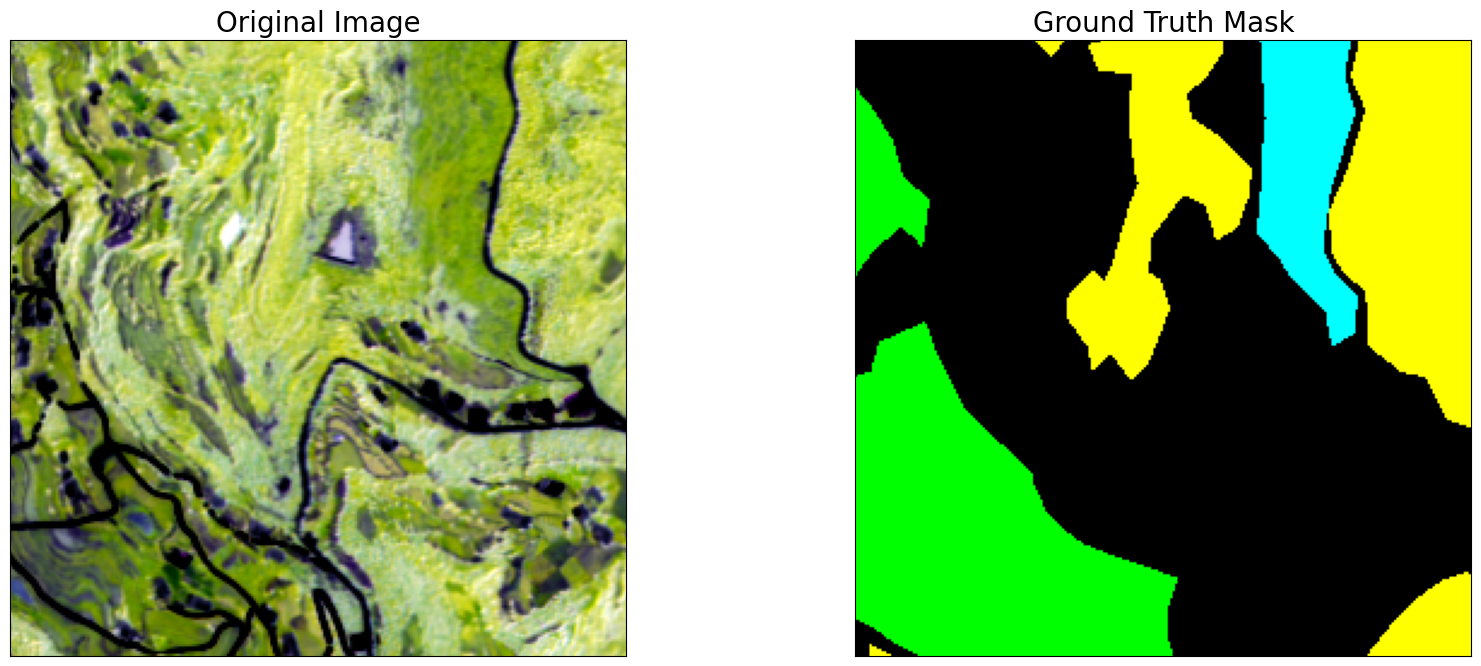

In [9]:
# Menggunakan train_metadata_df sebagai pengganti train_df
dataset = LandCoverDataset(train_metadata_df, class_rgb_values=select_class_rgb_values)

# Contoh penggunaan dataset untuk mendapatkan gambar dan mask secara acak
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]  # Memperbaiki indeks dari 2 menjadi random_idx untuk konsistensi

# Visualisasi gambar dan mask (jika Anda memiliki fungsi visualize terdefinisi)
visualize(
    original_image=image, 
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
)


## Defining Augmentations 


In [10]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)



def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(train_transform)

def get_test_augmentation():
    train_transform = [
        album.CenterCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
        
    return album.Compose(_transform)

## Visualize Augmented Images & Masks

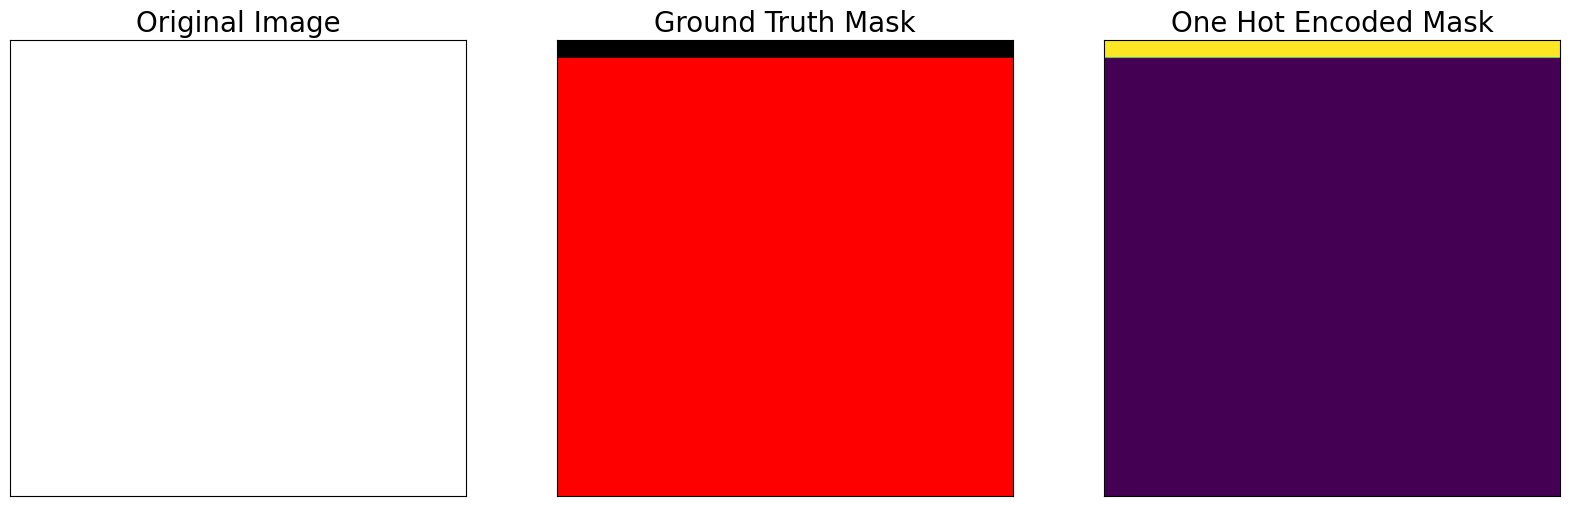

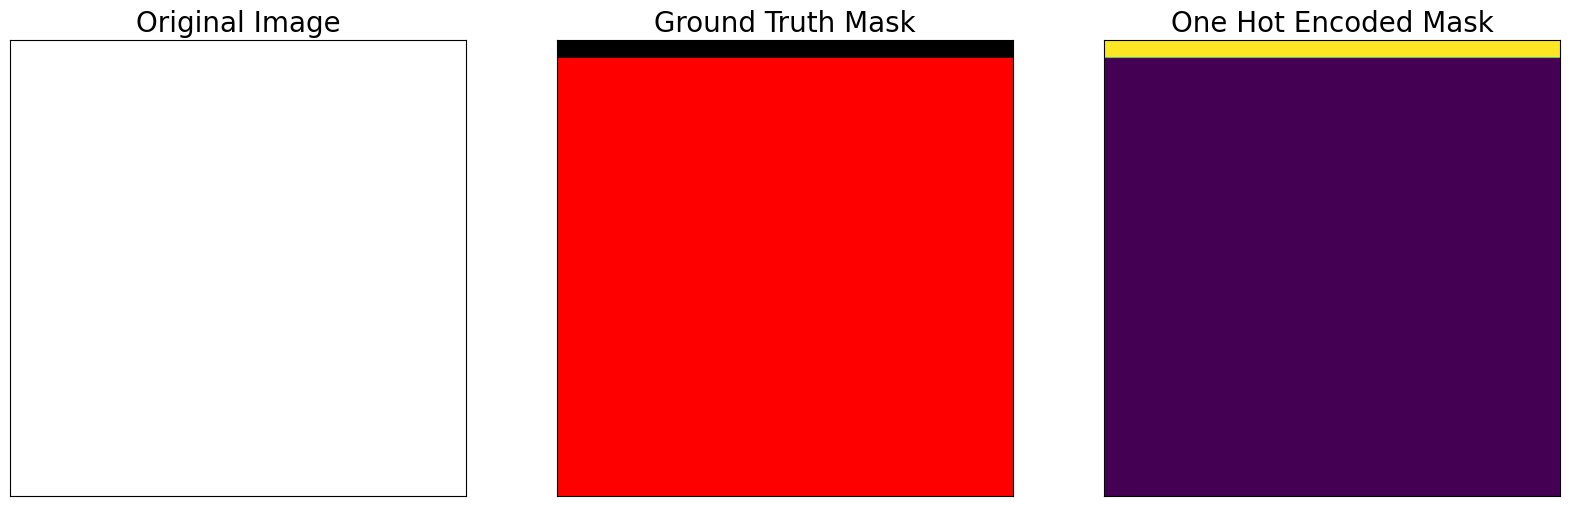

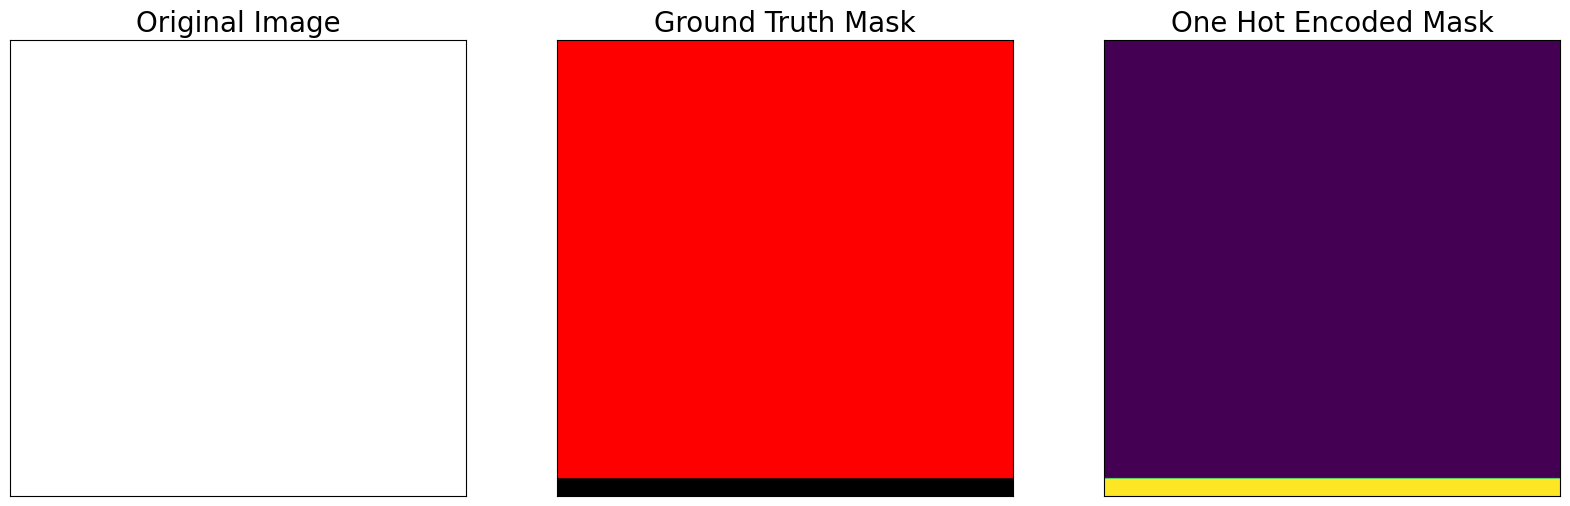

In [11]:
augmented_dataset = LandCoverDataset(
    train_metadata_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Model Definition

In [12]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Get Train / Val DataLoaders

In [13]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_metadata_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_metadata_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataset = LandCoverDataset(
    test_metadata_df, 
    augmentation=get_test_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

## Set Hyperparams

In [14]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = False

# Set num of epochs
EPOCHS = 1

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('./deeplabv3/best_model.pth'):
    model = torch.load('./deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

Loaded pre-trained DeepLabV3+ model!


In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


## Training DeepLabV3+

In [16]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './deeplabv3/best_model.pth')
            print('Model saved!')

CPU times: total: 0 ns
Wall time: 0 ns


## Prediction on Test Data

In [17]:
# load best saved model checkpoint from the current run
if os.path.exists('./deeplabv3/best_model.pth'):
    best_model = torch.load('./deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('./deeplabv3/best_model.pth'):
    best_model = torch.load('./deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


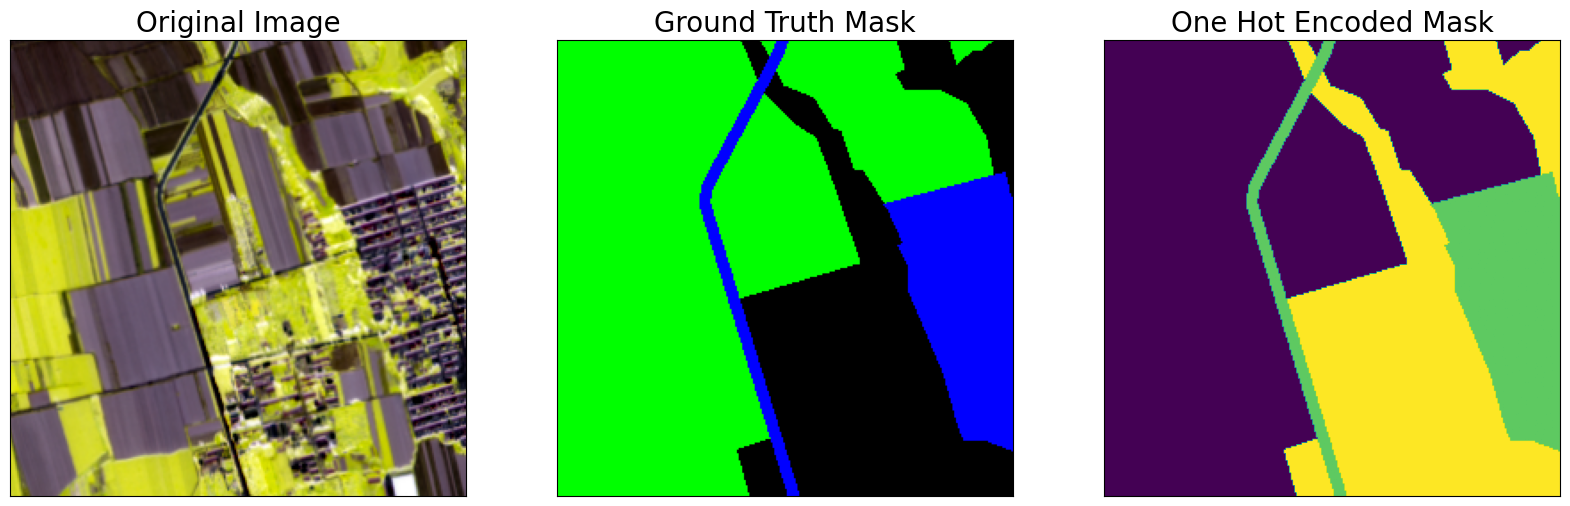

In [18]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))

#test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    test_metadata_df,
    augmentation=get_test_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [19]:
# Ambil jumlah kelas dari class_names yang sudah ada
num_classes = len(class_names)

In [20]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [21]:
best_model = model

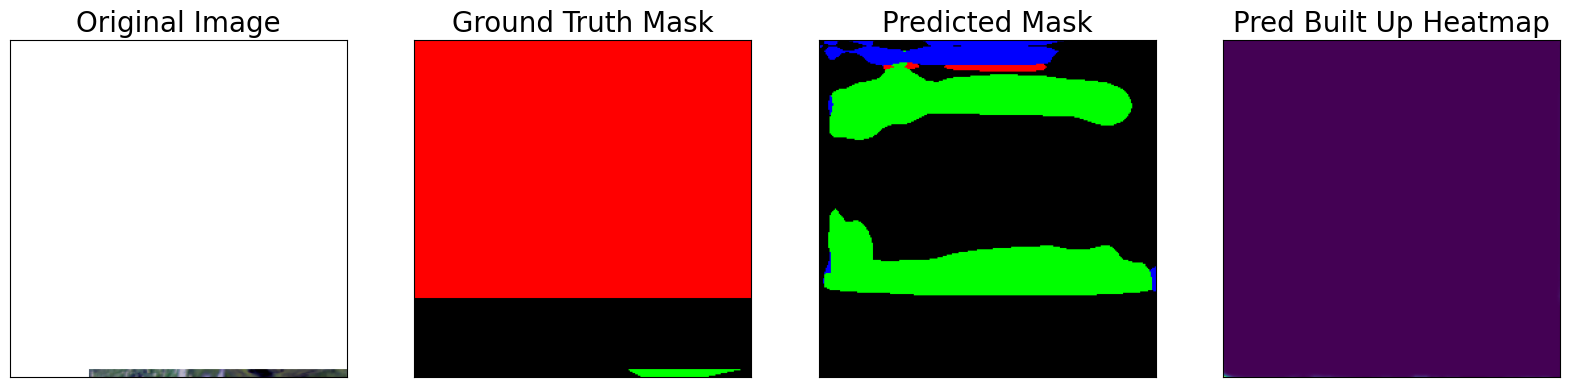

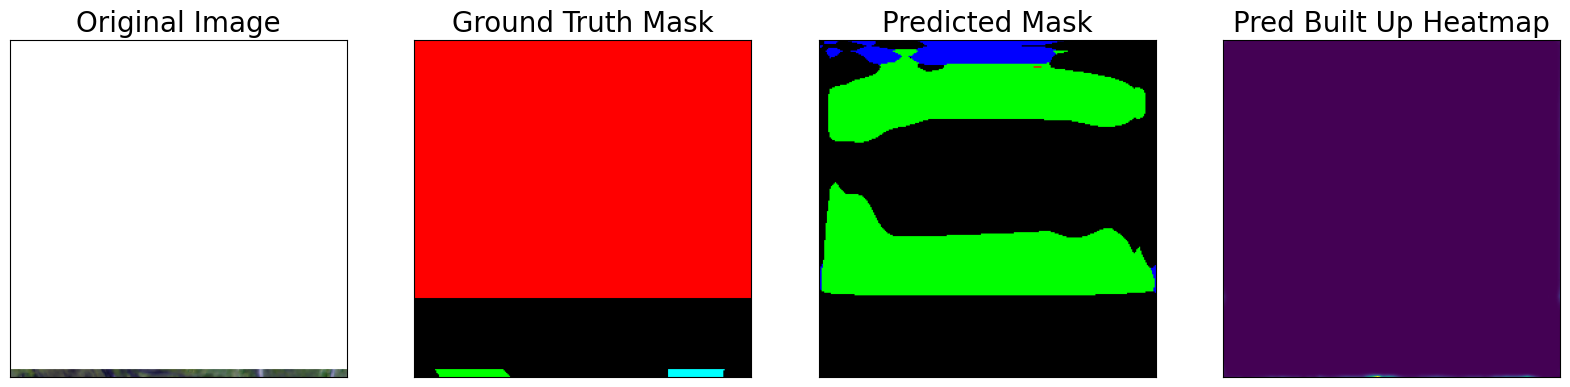

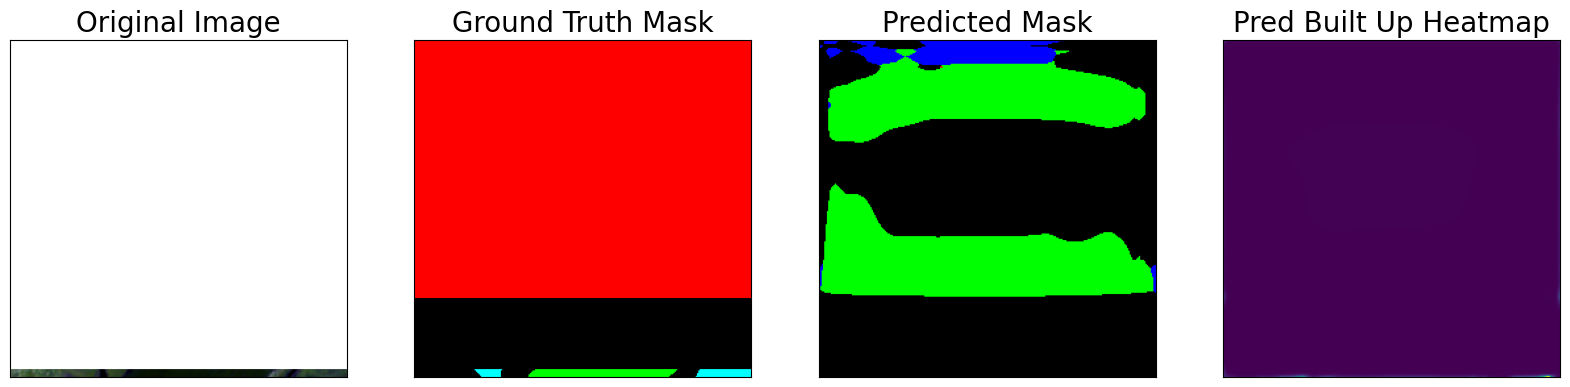

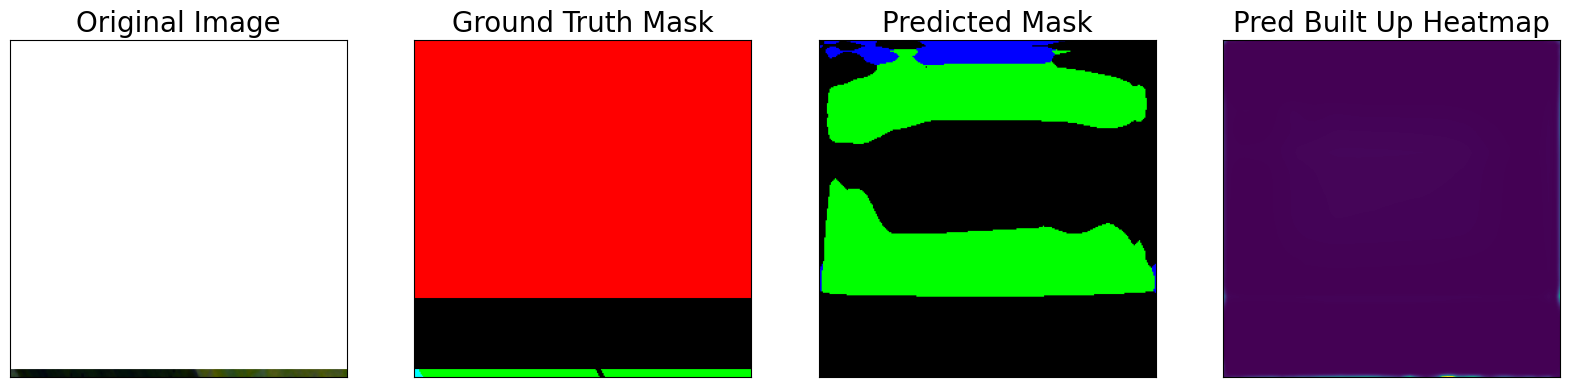

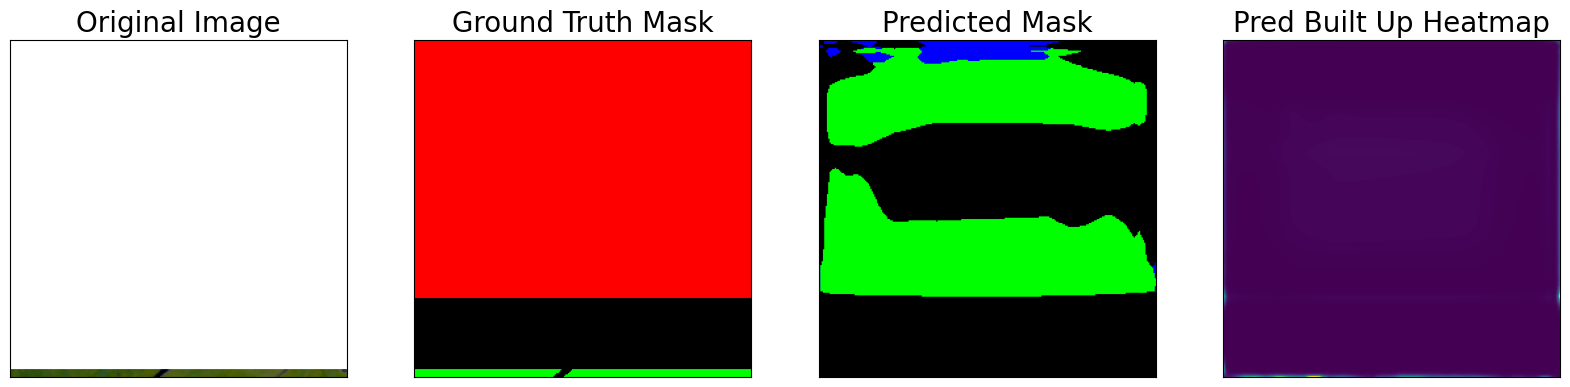

In [22]:
# Tentukan jumlah maksimum prediksi untuk divisualisasikan
max_visualizations = 5

for idx in range(len(test_dataset)):
    if idx >= max_visualizations:
        break  # Keluar dari loop setelah mencapai batas maksimum visualisasi

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_built_up_heatmap = pred_mask[:,:,select_classes.index('built-up')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_built_up_heatmap = pred_built_up_heatmap
    )

## Model Evaluation on Test Dataset

In [23]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#valid_logs = test_epoch.run(test_dataloader)
valid_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 686/686 [02:30<00:00,  4.55it/s, dice_loss - 0.2072, iou_score - 0.6775]
Evaluation on Test Data: 
Mean IoU Score: 0.6775
Mean Dice Loss: 0.2072


## Plot Dice Loss & IoU Metric for Train vs. Val

In [24]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

NameError: name 'train_logs_list' is not defined

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

NameError: name 'train_logs_df' is not defined

<Figure size 2000x800 with 0 Axes>

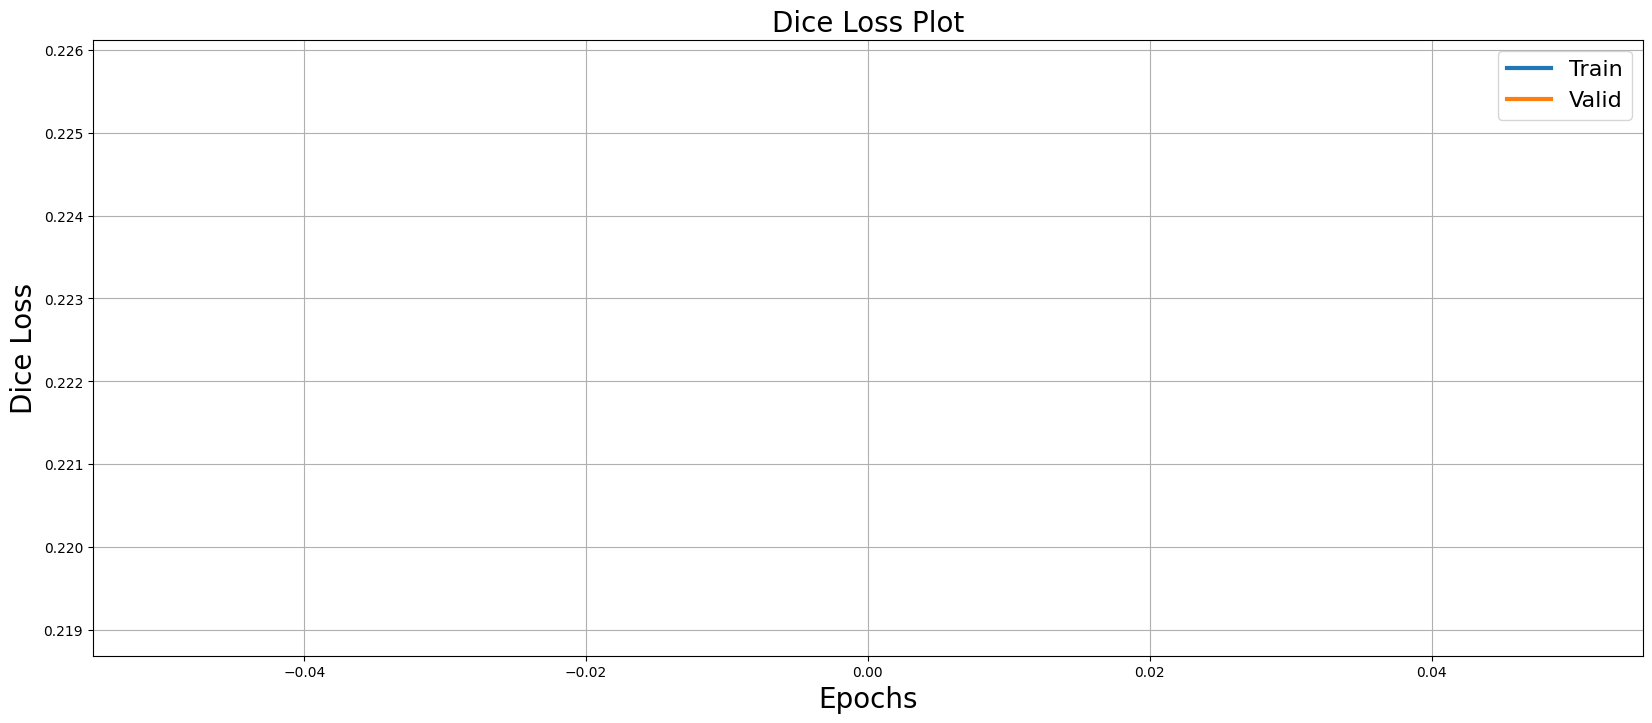

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np

def iou_per_class(preds, labels, num_classes):
    iou_list = []
    # Membuat prediksi menjadi format (N, H, W) dengan mengambil argmax jika diperlukan
    if preds.ndim == 4:  # (N, C, H, W)
        preds = np.argmax(preds, axis=1).reshape(-1)
    else:  # (N, H, W)
        preds = preds.reshape(-1)
    
    # Menyamakan format label jika diperlukan
    if labels.ndim == 4:  # (N, C, H, W)
        labels = np.argmax(labels, axis=1).reshape(-1)
    else:  # (N, H, W)
        labels = labels.reshape(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = pred_inds.sum() + label_inds.sum() - intersection

        if union == 0:
            iou_list.append(float('nan'))  # Avoid division by zero
        else:
            iou_list.append(float(intersection) / max(union, 1))
    
    return iou_list


In [26]:
def validate_model(model, dataloader, device, num_classes):
    model.eval()
    iou_scores = np.zeros(num_classes)
    count = 0  # Menghitung jumlah batch untuk rata-rata yang benar

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs).data.cpu().numpy()  # Jika model menggunakan sigmoid
            targets = masks.data.cpu().numpy()

            iou_scores_batch = iou_per_class(outputs, targets, num_classes)
            iou_scores += np.nan_to_num(iou_scores_batch)
            count += 1

    # Rata-rata IoU skor tiap kelas
    iou_scores /= count
    
    return iou_scores


In [27]:
# Hitung IoU tiap kelas pada validasi dataset
iou_scores = validate_model(model, valid_loader, DEVICE, len(CLASSES))

# Menampilkan IoU untuk setiap kelas
for cls_name, iou_score in zip(CLASSES, iou_scores):
    print(f"{cls_name}: IoU = {iou_score:.4f}")


built-up: IoU = 0.2578
farmland: IoU = 0.4964
forest: IoU = 0.0000
meadow: IoU = 0.1699
water: IoU = 0.3757
unknown: IoU = 0.5355


In [31]:
def calculate_confusion_matrix_elements(preds, labels, num_classes):
    TP = np.zeros(num_classes)
    TN = np.zeros(num_classes)
    FP = np.zeros(num_classes)
    FN = np.zeros(num_classes)
    
    for cls in range(num_classes):
        pred_cls = preds == cls
        true_cls = labels == cls
        
        TP[cls] = np.logical_and(pred_cls, true_cls).sum()
        TN[cls] = np.logical_and(~pred_cls, ~true_cls).sum()
        FP[cls] = np.logical_and(pred_cls, ~true_cls).sum()
        FN[cls] = np.logical_and(~pred_cls, true_cls).sum()
    
    total = TP + TN + FP + FN
    TP /= total
    TN /= total
    FP /= total
    FN /= total
    
    return TP, TN, FP, FN

def print_confusion_matrix_elements(TP, TN, FP, FN, class_names):
    """ Mencetak confusion matrix untuk setiap kelas. """
    for i, name in enumerate(class_names):
        print(f"Class: {name}")
        print(f"  True Positives: {TP[i]}")
        print(f"  True Negatives: {TN[i]}")
        print(f"  False Positives: {FP[i]}")
        print(f"  False Negatives: {FN[i]}")
        print("")


In [32]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

# Asumsi 'model' adalah model yang telah dilatih dan 'test_loader' adalah DataLoader untuk dataset pengujian.
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Menyimpan prediksi dan label sebenarnya
all_preds = []
all_labels = []

with torch.no_grad():
    for images, true_masks in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = torch.argmax(true_masks, dim=1).cpu().numpy()  # asumsikan mask telah one-hot encoded
        
        all_preds.extend(preds)
        all_labels.extend(labels)

# Mengonversi list ke numpy array
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Menghitung elemen-elemen confusion matrix
TP, TN, FP, FN = calculate_confusion_matrix_elements(all_preds, all_labels, len(class_names))
print_confusion_matrix_elements(TP, TN, FP, FN, class_names)


100%|██████████| 686/686 [03:04<00:00,  3.72it/s]


Class: built-up
  True Positives: 0.03516722142522606
  True Negatives: 0.9142365080274576
  False Positives: 0.004732042985476836
  False Negatives: 0.04586422756183947

Class: farmland
  True Positives: 0.14570936308657811
  True Negatives: 0.7916602476692756
  False Positives: 0.042506907493658035
  False Negatives: 0.02012348175048828

Class: forest
  True Positives: 0.0
  True Negatives: 0.9562496207545867
  False Positives: 0.0
  False Negatives: 0.043750379245413286

Class: meadow
  True Positives: 0.27834897555693244
  True Negatives: 0.6513971768037223
  False Positives: 0.05066291653380102
  False Negatives: 0.019590931105544197

Class: water
  True Positives: 0.09916279406311213
  True Negatives: 0.8399277261672841
  False Positives: 0.046127030175211824
  False Negatives: 0.014782449594392027

Class: unknown
  True Positives: 0.20420082804065404
  True Negatives: 0.6091179027501765
  False Positives: 0.09338192063934948
  False Negatives: 0.09329934856981995



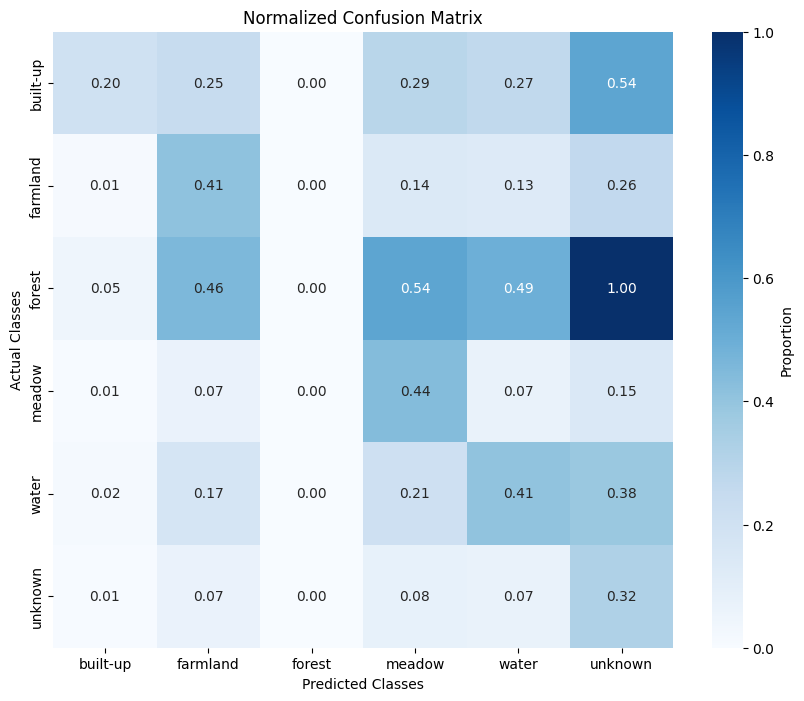

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming class_names and num_classes are defined as follows:
class_names = ['built-up', 'farmland', 'forest', 'meadow', 'water', 'unknown']
num_classes = len(class_names)

# Assuming you have arrays for TP, TN, FP, FN already calculated from your model's evaluation
# These should be calculated as shown earlier or using your own specific method

# Calculating the confusion matrix with actual TP, TN, FP, FN
confusion_matrix = np.zeros((num_classes, num_classes))

# Fill the diagonal with the proportion of true positives
for i in range(num_classes):
    confusion_matrix[i, i] = TP[i]  # TP are correctly on the diagonal

# Adding false positives to each row based on predictions made
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            confusion_matrix[i, j] = FP[j]  # FP[j] means FPs for class j predicted as class i

# Normalize each row by the total number of actual instances of each class (TP + FN for class i)
total_actual = TP + FN  # This is the sum of true positives and false negatives for each class
confusion_matrix_normalized = confusion_matrix / total_actual[:, np.newaxis]  # Broadcasting to normalize rows

# Normalize entire matrix so that the maximum value is 1
max_value = np.max(confusion_matrix_normalized)
confusion_matrix_normalized = confusion_matrix_normalized / max_value  # Scale down everything by the largest value

# Convert to DataFrame for easier plotting
confusion_df_normalized = pd.DataFrame(confusion_matrix_normalized, index=class_names, columns=class_names)

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df_normalized, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()
